In [70]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import json
import matplotlib.dates as dates
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
keras = tf.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM

from math import sqrt
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV

## Load in currently mined data-set

In [2]:
#load this line for the training-data that includes the vector columns
#mined_df = pd.read_csv('data/FLO_data_miner-changeVectors.csv', index_col=0)
#load this line for current data
mined_df = pd.read_csv('data/FLO_data_miner.csv', index_col=0)
#mined_df.timestamp = pd.to_datetime(mined_df.timestamp)

In [3]:
# bouncing out some raw data for Devon to play with
# devon_df = mined_df[['FLOlast', 'scrypt_price', 'scrypt_avail', 'scrypt_rented', 'scrypt_last30']]
# devon_df.to_csv('data/for_devon.csv')

#conforming the input dataframe to prep for training
mined_df = mined_df.reset_index(drop=True)
pd.set_option('display.max_columns', None)
mined_df.tail(50)

,timestamp,FLONetworkHashesPs,FLOdifficulty,FLOblocks,BTCdifficulty,BTCblocks,FLOvolume,FLOopenBuy,FLOopenSell,FLOlow,FLOhigh,FLObid,FLOask,FLObaseVol,BTCvolume,BTCopenBuy,BTCopenSell,BTClow,BTChigh,BTCbid,BTCask,BTCbaseVol,FLOlast,BTClast,scrypt_price,scrypt_avail,scrypt_rented,scrypt_last30,sha_price,sha_avail,sha_rented,sha_last30,BTChashrate
6938,2020-05-27 14:29:52.212266,1.288665e+11,1291,4130777,1.513804e+13,631910.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,564.068420,5576,4147,9190.0,8699.499,9143.180,9143.882,5.048696e+06,0.000003,9143.173,0.000198,373,168,0.000404,0.000009,364,122,0.000172,9.556956e+10
6939,2020-05-27 14:34:57.431765,1.247714e+11,1134,4130785,1.513804e+13,631910.0,189416.611022,184,1396,0.000003,0.000003,0.000003,0.000003,0.611797,574.055225,5575,4152,9190.0,8699.499,9145.096,9146.622,5.140376e+06,0.000003,9147.342,0.000198,373,168,0.000404,0.000009,369,121,0.000172,9.481704e+10
6940,2020-05-27 14:40:04.804693,1.252101e+11,1174,4130793,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,568.535918,5580,4151,9190.0,8699.499,9150.325,9153.000,5.092836e+06,0.000003,9151.295,0.000198,374,168,0.000404,0.000009,366,122,0.000172,9.481704e+10
6941,2020-05-27 14:45:09.595415,1.195685e+11,1077,4130796,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,570.302001,5583,4146,9190.0,8699.499,9166.256,9169.000,5.109419e+06,0.000003,9168.999,0.000197,374,167,0.000404,0.000009,366,122,0.000172,9.481704e+10
6942,2020-05-27 14:50:13.751701,1.306143e+11,1067,4130805,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,572.138378,5577,4146,9190.0,8699.499,9146.903,9152.683,5.126476e+06,0.000003,9153.000,0.000197,375,166,0.000404,0.000009,366,123,0.000172,9.556956e+10
6943,2020-05-27 14:55:18.027936,1.181553e+11,1059,4130807,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,566.416858,5577,4148,9190.0,8699.499,9151.108,9155.625,5.076507e+06,0.000003,9155.624,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10
6944,2020-05-27 15:00:24.238689,1.114742e+11,1029,4130808,1.513804e+13,631912.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.303497,5580,4151,9190.0,8699.499,9155.317,9161.057,5.103200e+06,0.000003,9156.664,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10
6945,2020-05-27 15:05:30.064596,1.253191e+11,1187,4130829,1.513804e+13,631914.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.846538,5580,4145,9190.0,8699.499,9167.593,9170.000,5.108230e+06,0.000003,9167.258,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10
6946,2020-05-27 15:10:34.799231,1.197372e+11,1239,4130834,1.513804e+13,631914.0,188622.861022,183,1394,0.000003,0.000003,0.000003,0.000003,0.609233,587.697997,5573,4146,9190.0,8699.499,9172.340,9175.000,5.272173e+06,0.000003,9175.000,0.000197,374,167,0.000404,0.000009,367,123,0.000172,9.707459e+10
6947,2020-05-27 15:15:39.373002,1.181485e+11,1211,4130840,1.513804e+13,631915.0,188448.306215,182,1394,0.000003,0.000003,0.000003,0.000003,0.608678,586.878075,5574,4147,9190.0,8699.499,9165.001,9169.505,5.265910e+06,0.000003,9161.020,0.000197,373,168,0.000404,0.000009,367,123,0.000172,9.707459e+10


## Feature engineering the change vectors

In [4]:
#Calculate and store all the change vectors, then drop the colums used for calculation.
mined_df['30m_btc'] = mined_df['BTClast'].shift(periods=6)
mined_df['1h_btc'] = mined_df['BTClast'].shift(periods=12)
mined_df['1.5h_btc'] = mined_df['BTClast'].shift(periods=18)
mined_df['2h_btc'] = mined_df['BTClast'].shift(periods=24)
mined_df['2.5h_btc'] = mined_df['BTClast'].shift(periods=30)
mined_df['3h_btc'] = mined_df['BTClast'].shift(periods=36)

mined_df['30m_change'] = mined_df['BTClast'] - mined_df['30m_btc']
mined_df['1h_change'] = mined_df['BTClast'] - mined_df['1h_btc']
mined_df['1.5h_change'] = mined_df['BTClast'] - mined_df['1.5h_btc']
mined_df['2h_change'] = mined_df['BTClast'] - mined_df['2h_btc']
mined_df['2.5h_change'] = mined_df['BTClast'] - mined_df['2.5h_btc']
mined_df['3h_change'] = mined_df['BTClast'] - mined_df['3h_btc']

mined_df.drop(['30m_btc','1h_btc','1.5h_btc','2h_btc','2.5h_btc','3h_btc'], axis=1, inplace=True)
mined_df.tail(50)

,timestamp,FLONetworkHashesPs,FLOdifficulty,FLOblocks,BTCdifficulty,BTCblocks,FLOvolume,FLOopenBuy,FLOopenSell,FLOlow,FLOhigh,FLObid,FLOask,FLObaseVol,BTCvolume,BTCopenBuy,BTCopenSell,BTClow,BTChigh,BTCbid,BTCask,BTCbaseVol,FLOlast,BTClast,scrypt_price,scrypt_avail,scrypt_rented,scrypt_last30,sha_price,sha_avail,sha_rented,sha_last30,BTChashrate,30m_change,1h_change,1.5h_change,2h_change,2.5h_change,3h_change
6938,2020-05-27 14:29:52.212266,1.288665e+11,1291,4130777,1.513804e+13,631910.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,564.068420,5576,4147,9190.0,8699.499,9143.180,9143.882,5.048696e+06,0.000003,9143.173,0.000198,373,168,0.000404,0.000009,364,122,0.000172,9.556956e+10,-5.661,-44.557,-6.601,-29.792,8.696,5.105
6939,2020-05-27 14:34:57.431765,1.247714e+11,1134,4130785,1.513804e+13,631910.0,189416.611022,184,1396,0.000003,0.000003,0.000003,0.000003,0.611797,574.055225,5575,4152,9190.0,8699.499,9145.096,9146.622,5.140376e+06,0.000003,9147.342,0.000198,373,168,0.000404,0.000009,369,121,0.000172,9.481704e+10,17.884,-20.932,8.598,-35.487,-23.295,4.667
6940,2020-05-27 14:40:04.804693,1.252101e+11,1174,4130793,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,568.535918,5580,4151,9190.0,8699.499,9150.325,9153.000,5.092836e+06,0.000003,9151.295,0.000198,374,168,0.000404,0.000009,366,122,0.000172,9.481704e+10,14.866,-10.638,-4.308,-24.382,-9.124,23.618
6941,2020-05-27 14:45:09.595415,1.195685e+11,1077,4130796,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,570.302001,5583,4146,9190.0,8699.499,9166.256,9169.000,5.109419e+06,0.000003,9168.999,0.000197,374,167,0.000404,0.000009,366,122,0.000172,9.481704e+10,39.000,31.233,3.999,-1.054,-9.986,42.555
6942,2020-05-27 14:50:13.751701,1.306143e+11,1067,4130805,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,572.138378,5577,4146,9190.0,8699.499,9146.903,9152.683,5.126476e+06,0.000003,9153.000,0.000197,375,166,0.000404,0.000009,366,123,0.000172,9.556956e+10,6.703,7.668,-7.488,-13.822,-28.235,25.760
6943,2020-05-27 14:55:18.027936,1.181553e+11,1059,4130807,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,566.416858,5577,4148,9190.0,8699.499,9151.108,9155.625,5.076507e+06,0.000003,9155.624,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,13.329,14.380,-24.376,1.901,-7.120,32.439
6944,2020-05-27 15:00:24.238689,1.114742e+11,1029,4130808,1.513804e+13,631912.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.303497,5580,4151,9190.0,8699.499,9155.317,9161.057,5.103200e+06,0.000003,9156.664,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,13.491,7.830,-31.066,6.890,-16.301,22.187
6945,2020-05-27 15:05:30.064596,1.253191e+11,1187,4130829,1.513804e+13,631914.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.846538,5580,4145,9190.0,8699.499,9167.593,9170.000,5.108230e+06,0.000003,9167.258,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,19.916,37.800,-1.016,28.514,-15.571,-3.379
6946,2020-05-27 15:10:34.799231,1.197372e+11,1239,4130834,1.513804e+13,631914.0,188622.861022,183,1394,0.000003,0.000003,0.000003,0.000003,0.609233,587.697997,5573,4146,9190.0,8699.499,9172.340,9175.000,5.272173e+06,0.000003,9175.000,0.000197,374,167,0.000404,0.000009,367,123,0.000172,9.707459e+10,23.705,38.571,13.067,19.397,-0.677,14.581
6947,2020-05-27 15:15:39.373002,1.181485e+11,1211,4130840,1.513804e+13,631915.0,188448.306215,182,1394,0.000003,0.000003,0.000003,0.000003,0.608678,586.878075,5574,4147,9190.0,8699.499,9165.001,9169.505,5.265910e+06,0.000003,9161.020,0.000197,373,168,0.000404,0.000009,367,123,0.000172,9.707459e+10,-7.979,31.021,23.254,-3.980,-9.033,-17.965


In [5]:
# Generate the target values: 5min increments means 48 rows represents 4hr of time change
mined_df['target_btc'] = mined_df['BTClast'].shift(periods=-36)
mined_df.tail(50)

,timestamp,FLONetworkHashesPs,FLOdifficulty,FLOblocks,BTCdifficulty,BTCblocks,FLOvolume,FLOopenBuy,FLOopenSell,FLOlow,FLOhigh,FLObid,FLOask,FLObaseVol,BTCvolume,BTCopenBuy,BTCopenSell,BTClow,BTChigh,BTCbid,BTCask,BTCbaseVol,FLOlast,BTClast,scrypt_price,scrypt_avail,scrypt_rented,scrypt_last30,sha_price,sha_avail,sha_rented,sha_last30,BTChashrate,30m_change,1h_change,1.5h_change,2h_change,2.5h_change,3h_change,target_btc
6938,2020-05-27 14:29:52.212266,1.288665e+11,1291,4130777,1.513804e+13,631910.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,564.068420,5576,4147,9190.0,8699.499,9143.180,9143.882,5.048696e+06,0.000003,9143.173,0.000198,373,168,0.000404,0.000009,364,122,0.000172,9.556956e+10,-5.661,-44.557,-6.601,-29.792,8.696,5.105,9190.888
6939,2020-05-27 14:34:57.431765,1.247714e+11,1134,4130785,1.513804e+13,631910.0,189416.611022,184,1396,0.000003,0.000003,0.000003,0.000003,0.611797,574.055225,5575,4152,9190.0,8699.499,9145.096,9146.622,5.140376e+06,0.000003,9147.342,0.000198,373,168,0.000404,0.000009,369,121,0.000172,9.481704e+10,17.884,-20.932,8.598,-35.487,-23.295,4.667,9201.500
6940,2020-05-27 14:40:04.804693,1.252101e+11,1174,4130793,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,568.535918,5580,4151,9190.0,8699.499,9150.325,9153.000,5.092836e+06,0.000003,9151.295,0.000198,374,168,0.000404,0.000009,366,122,0.000172,9.481704e+10,14.866,-10.638,-4.308,-24.382,-9.124,23.618,9200.827
6941,2020-05-27 14:45:09.595415,1.195685e+11,1077,4130796,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,570.302001,5583,4146,9190.0,8699.499,9166.256,9169.000,5.109419e+06,0.000003,9168.999,0.000197,374,167,0.000404,0.000009,366,122,0.000172,9.481704e+10,39.000,31.233,3.999,-1.054,-9.986,42.555,9213.473
6942,2020-05-27 14:50:13.751701,1.306143e+11,1067,4130805,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,572.138378,5577,4146,9190.0,8699.499,9146.903,9152.683,5.126476e+06,0.000003,9153.000,0.000197,375,166,0.000404,0.000009,366,123,0.000172,9.556956e+10,6.703,7.668,-7.488,-13.822,-28.235,25.760,9210.519
6943,2020-05-27 14:55:18.027936,1.181553e+11,1059,4130807,1.513804e+13,631911.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,566.416858,5577,4148,9190.0,8699.499,9151.108,9155.625,5.076507e+06,0.000003,9155.624,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,13.329,14.380,-24.376,1.901,-7.120,32.439,9199.981
6944,2020-05-27 15:00:24.238689,1.114742e+11,1029,4130808,1.513804e+13,631912.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.303497,5580,4151,9190.0,8699.499,9155.317,9161.057,5.103200e+06,0.000003,9156.664,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,13.491,7.830,-31.066,6.890,-16.301,22.187,9166.764
6945,2020-05-27 15:05:30.064596,1.253191e+11,1187,4130829,1.513804e+13,631914.0,189416.611022,184,1397,0.000003,0.000003,0.000003,0.000003,0.611797,569.846538,5580,4145,9190.0,8699.499,9167.593,9170.000,5.108230e+06,0.000003,9167.258,0.000197,373,167,0.000404,0.000009,367,122,0.000172,9.556956e+10,19.916,37.800,-1.016,28.514,-15.571,-3.379,9171.503
6946,2020-05-27 15:10:34.799231,1.197372e+11,1239,4130834,1.513804e+13,631914.0,188622.861022,183,1394,0.000003,0.000003,0.000003,0.000003,0.609233,587.697997,5573,4146,9190.0,8699.499,9172.340,9175.000,5.272173e+06,0.000003,9175.000,0.000197,374,167,0.000404,0.000009,367,123,0.000172,9.707459e+10,23.705,38.571,13.067,19.397,-0.677,14.581,9178.795
6947,2020-05-27 15:15:39.373002,1.181485e+11,1211,4130840,1.513804e+13,631915.0,188448.306215,182,1394,0.000003,0.000003,0.000003,0.000003,0.608678,586.878075,5574,4147,9190.0,8699.499,9165.001,9169.505,5.265910e+06,0.000003,9161.020,0.000197,373,168,0.000404,0.000009,367,123,0.000172,9.707459e+10,-7.979,31.021,23.254,-3.980,-9.033,-17.965,9181.885


In [97]:
# Slice out the data needed for training the current model
# NOTE: we don't start gathering BTC hashrate until row 1898, so that's why we set that as first slice
train_df = mined_df.iloc[1898:mined_df.shape[0]-101, :]
train_df.tail()

,timestamp,FLONetworkHashesPs,FLOdifficulty,FLOblocks,BTCdifficulty,BTCblocks,FLOvolume,FLOopenBuy,FLOopenSell,FLOlow,FLOhigh,FLObid,FLOask,FLObaseVol,BTCvolume,BTCopenBuy,BTCopenSell,BTClow,BTChigh,BTCbid,BTCask,BTCbaseVol,FLOlast,BTClast,scrypt_price,scrypt_avail,scrypt_rented,scrypt_last30,sha_price,sha_avail,sha_rented,sha_last30,BTChashrate,30m_change,1h_change,1.5h_change,2h_change,2.5h_change,3h_change,target_btc
6882,2020-05-27 09:45:16.952977,6.882710e+10,1237,4130356,1.513804e+13,631884.0,228399.706949,183,1403,0.000003,0.000003,0.000003,0.000003,0.732844,514.976423,5479,4338,8955.0,8699.499,8910.532,8917.681,4.553301e+06,0.000003,8917.388,0.0002,363,172,0.000243,0.000009,354,123,0.000089,9.632208e+10,-8.824,-3.568,42.388,67.221,77.654,73.750,9166.822
6883,2020-05-27 09:50:23.853228,6.581976e+10,1290,4130358,1.513804e+13,631884.0,228868.686132,182,1403,0.000003,0.000003,0.000003,0.000003,0.734336,514.838282,5482,4336,8955.0,8699.499,8918.331,8926.151,4.552074e+06,0.000003,8922.254,0.0002,362,172,0.000243,0.000009,354,123,0.000089,9.556956e+10,-0.990,-6.771,54.295,68.649,78.212,84.842,9153.723
6884,2020-05-27 09:55:27.994511,6.581976e+10,1290,4130358,1.513804e+13,631884.0,231032.797837,181,1404,0.000003,0.000003,0.000003,0.000003,0.741101,515.304773,5476,4337,8955.0,8699.499,8916.218,8921.796,4.556236e+06,0.000003,8921.793,0.0002,363,171,0.000243,0.000009,352,124,0.000089,9.406453e+10,-6.208,-4.186,-17.207,71.660,76.003,85.559,9149.774
6885,2020-05-27 10:00:33.647250,6.163632e+10,1150,4130362,1.513804e+13,631884.0,230838.797837,179,1407,0.000003,0.000003,0.000003,0.000003,0.740484,514.363976,5480,4329,8955.0,8699.499,8928.791,8936.559,4.548041e+06,0.000003,8932.455,0.0002,361,172,0.000243,0.000010,351,124,0.000089,9.406453e+10,6.653,2.455,-2.922,98.305,94.081,96.922,9138.744
6886,2020-05-27 10:05:38.044951,6.581548e+10,1139,4130371,1.513804e+13,631884.0,230838.797837,179,1407,0.000003,0.000003,0.000003,0.000003,0.740484,512.710766,5473,4330,8955.0,8699.499,8934.209,8940.207,4.533481e+06,0.000003,8940.210,0.0002,361,172,0.000243,0.000009,350,122,0.000089,9.255949e+10,25.045,16.588,11.389,75.729,97.617,99.977,9155.603


## Splitting and fitting

In [76]:
X = train_df.drop(['timestamp', 'target_btc','FLONetworkHashesPs', 'FLOdifficulty', 'FLOblocks', 'FLOvolume', 'FLOopenBuy', 'FLOopenSell', 'FLOlow', 'FLOhigh', 'FLObid', 'FLOask', 'FLObaseVol', 'FLOlast'], axis=1)
y = train_df['target_btc']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape , y_train.shape

((1600, 26), (1600,))

In [78]:
dum_guess = round(train_df['target_btc'].mean())
print("Base Model will guess: "+ str(dum_guess))
print("Our baseline RMSE is : " + str(round(sqrt(mean_squared_error(y, np.full(y.shape,dum_guess))))))

Base Model will guess: 9109.0
Our baseline RMSE is : 258


In [79]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

In [80]:
print("MSE : " + str(mean_squared_error(y_test, lin_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, lin_preds))))

MSE : 5094.2616833314005
RMSE: 71.37409672515233


In [81]:
rf_model = RandomForestRegressor(n_estimators=125,
                            max_features=5,
                            max_depth=110,
                           #random_state=0,
                            min_samples_split=10,
                            min_samples_leaf=7)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, rf_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, rf_pred))))

MSE : 617.0646489059595
RMSE: 24.84078599613868


In [82]:
model_g = GradientBoostingRegressor(learning_rate=0.033,
                                   n_estimators=480,
                                   min_samples_leaf=7,
                                   max_depth=89)
model_g.fit(X_train,y_train)
preds_gb = model_g.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, preds_gb)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, preds_gb))))

MSE : 524.3191660898767
RMSE: 22.898016640964272


In [ ]:
ada_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=480,
                                            #max_features=4,
                                            max_depth=89,
                                            min_samples_split=2,
                                            min_samples_leaf=7),
                            learning_rate=0.033,
                            n_estimators=80)
ada_model.fit(X_train,y_train)
ada_preds = ada_model.predict(X_test)
print("R2 Score: " + str(r2_score(y_test, ada_preds)))
print("MSE : " + str(mean_squared_error(y_test, ada_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, ada_preds))))

## GRIIIID SEEEAAARCH

In [288]:
parameters = {
    'learning_rate': [0.033,0.034,0.035],
    'n_estimators':[400,410,420,430,450,460,470,480,500],
    'min_samples_leaf':[5,6,7,8],
    'max_depth':[87,88,89,90]
}
grid_search_tune = GridSearchCV(model_g, parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=2, verbose=3)
grid_search_tune.fit(X_train, y_train)
print("Best parameters set:")
print(grid_search_tune.best_estimator_)

Fitting 2 folds for each of 432 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 36.5min finished


Best parameters set:
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.033, loss='ls',
                          max_depth=89, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=7, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=480,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


## Exploring LSTM Neural Net implimentation

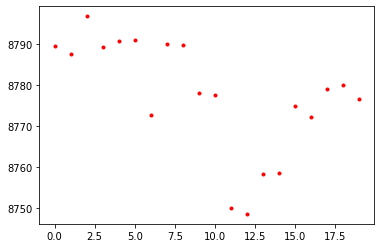

In [96]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test
plt.plot(x_train[-1], 'r.')

In [68]:
n_prev = 20

x_train, x_test, y_train, y_test = split_and_windowize(np.array(mined_df['BTClast']), n_prev, fraction_test=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
y_train[-20]

array([7670.799, 7679.571, 7676.682, ..., 8779.986, 8776.534, 8785.   ])

In [73]:
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(Activation("tanh"))
model.add(Dropout(0.2))
model.add(keras.layers.LSTM(50, return_sequences=False))
model.add(Activation("tanh"))
model.add(Dropout(0.2))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [74]:
model.fit(np.array(x_train), np.array(y_train), batch_size=32, epochs=30)

Train on 6234 samples
Epoch 1/30
6234/6234 [==============================] - 35s 6ms/sample - loss: 85379721.6811
Epoch 2/30
6234/6234 [==============================] - 21s 3ms/sample - loss: 85227643.3699
Epoch 3/30
6234/6234 [==============================] - 21s 3ms/sample - loss: 85087266.4382
Epoch 4/30
6234/6234 [==============================] - 21s 3ms/sample - loss: 84948873.0908
Epoch 5/30
6234/6234 [==============================] - 22s 3ms/sample - loss: 84808328.6776
Epoch 6/30
6234/6234 [==============================] - 22s 4ms/sample - loss: 84668832.9830
Epoch 7/30
6234/6234 [==============================] - 22s 4ms/sample - loss: 84528626.0533
Epoch 8/30
6234/6234 [==============================] - 22s 4ms/sample - loss: 84389096.8932
Epoch 9/30
6234/6234 [==============================] - 22s 4ms/sample - loss: 84250078.2368
Epoch 10/30
6234/6234 [==============================] - 23s 4ms/sample - loss: 84109992.8495
Epoch 11/30
6234/6234 [========================

In [72]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 20, 32)            4352      
_________________________________________________________________
activation (Activation)      (None, 20, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 32)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                16600     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [66]:
y_pred = model.predict(x_test)
#x_test

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot( y_pred, 'b.-', label='predictions')
ax.plot( y_test, 'r.', label='actual')
#ax.plot(t[-len(y_test):], np.sin(t[-len(y_test):]), 'g-', label='ideal')
ax.legend()

# Looking at Live Predictions

In [85]:
X_l = mined_df.iloc[mined_df.shape[0]-100:mined_df.shape[0]-1, :]
X_live = X_l.drop(['timestamp', 'target_btc','FLONetworkHashesPs', 'FLOdifficulty', 'FLOblocks', 'FLOvolume', 'FLOopenBuy', 'FLOopenSell', 'FLOlow', 'FLOhigh', 'FLObid', 'FLOask', 'FLObaseVol', 'FLOlast'], axis=1)
live_prediction = model_g.predict(X_live)

In [86]:
live_prediction

array([9150.70505802, 9154.53253282, 9150.15185735, 9124.59224021,
       9120.75676269, 9118.93483982, 9118.96989262, 9115.92456829,
       9116.14338248, 9108.70185522, 9107.34131077, 9108.66605967,
       9119.89824403, 9115.7612576 , 9112.9279366 , 9109.97876957,
       9114.73681523, 9122.09924549, 9124.32608561, 9136.21185398,
       9136.03611447, 9106.25722962, 9107.57773383, 9127.10937816,
       8985.54391094, 8983.30975797, 9125.00585192, 9131.55414958,
       9132.51872678, 9131.98227329, 9130.52727043, 9131.95778731,
       9126.3790622 , 9136.38536627, 9136.91276626, 9136.96044797,
       9135.8175625 , 9135.94476052, 9136.10810558, 9132.48552985,
       9139.76781635, 9134.54945833, 9134.88785616, 9133.56508038,
       9134.29800778, 9124.13872314, 8975.07198441, 8983.73928554,
       8924.59439932, 8925.97284538, 8908.96895905, 8906.70811203,
       8925.4602422 , 8922.49411857, 8922.34436134, 8925.51873869,
       8923.34954878, 8912.93390105, 8923.63713577, 8907.11920

In [87]:
X_l['prediction'] = live_prediction
X_l.tail(100)

/Users/owenmorris/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timestamp,FLONetworkHashesPs,FLOdifficulty,FLOblocks,BTCdifficulty,BTCblocks,FLOvolume,FLOopenBuy,FLOopenSell,FLOlow,FLOhigh,FLObid,FLOask,FLObaseVol,BTCvolume,BTCopenBuy,BTCopenSell,BTClow,BTChigh,BTCbid,BTCask,BTCbaseVol,FLOlast,BTClast,scrypt_price,scrypt_avail,scrypt_rented,scrypt_last30,sha_price,sha_avail,sha_rented,sha_last30,BTChashrate,30m_change,1h_change,1.5h_change,2h_change,2.5h_change,3h_change,target_btc,prediction
6888,2020-05-27 10:15:47.088317,6.320387e+10,1051,4130379,1.513804e+13,631885.0,230838.797837,179,1407,0.000003,0.000003,0.000003,0.000003,0.740484,513.050815,5471,4328,8955.000,8699.499,8932.713,8936.449,4.536593e+06,0.000003,8935.259,0.000198,364,170,0.000243,0.000009,352,122,0.000089,9.331201e+10,17.871,9.047,14.303,60.259,85.092,95.525,9160.488,9150.705058
6889,2020-05-27 10:20:51.850743,6.438629e+10,1066,4130385,1.513804e+13,631885.0,231001.809360,178,1405,0.000003,0.000003,0.000003,0.000003,0.740993,511.559517,5475,4329,8955.000,8699.499,8937.027,8944.787,4.523426e+06,0.000003,8942.194,0.000198,364,170,0.000243,0.000009,351,122,0.000089,9.331201e+10,19.940,18.950,13.169,74.235,88.589,98.152,9180.000,9154.532533
6890,2020-05-27 10:25:55.942581,6.223478e+10,955,4130394,1.513804e+13,631885.0,231001.809360,178,1405,0.000003,0.000003,0.000003,0.000003,0.740993,485.622482,5475,4330,8955.000,8699.499,8949.834,8954.989,4.293283e+06,0.000003,8949.108,0.000198,365,169,0.000243,0.000009,350,122,0.000089,9.331201e+10,27.315,21.107,23.129,10.108,98.975,103.318,9187.730,9150.151857
6891,2020-05-27 10:31:01.388132,6.206138e+10,1179,4130404,1.513804e+13,631885.0,230197.603084,177,1402,0.000003,0.000003,0.000003,0.000003,0.738436,475.366062,5475,4169,9100.000,8699.499,9098.481,9100.000,4.207899e+06,0.000003,9096.001,0.000198,366,169,0.000243,0.000009,358,122,0.000089,9.331201e+10,163.546,170.199,166.001,160.624,261.851,257.627,9168.274,9124.592240
6892,2020-05-27 10:36:06.140852,6.206138e+10,1179,4130404,1.513804e+13,631886.0,230197.603084,177,1402,0.000003,0.000003,0.000003,0.000003,0.738436,486.358257,5514,4113,9180.525,8699.499,9095.803,9106.907,4.309938e+06,0.000003,9106.907,0.000198,365,169,0.000243,0.000009,358,120,0.000089,9.255949e+10,166.697,191.742,183.285,178.086,242.426,264.314,9161.933,9120.756763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982,2020-05-27 18:15:33.246852,1.107677e+11,1197,4131121,1.513804e+13,631938.0,165108.047255,183,1396,0.000003,0.000003,0.000003,0.000003,0.532464,623.237069,5640,4112,9230.000,8758.566,9173.468,9179.642,5.628991e+06,0.000003,9178.795,0.000195,354,170,0.000363,0.000009,346,136,0.000095,1.038472e+11,-22.032,3.025,0.384,34.317,46.668,3.795,NaN,8976.451468
6983,2020-05-27 18:20:36.727746,1.081614e+11,1173,4131123,1.513804e+13,631939.0,165108.047255,183,1396,0.000003,0.000003,0.000003,0.000003,0.532464,627.359354,5645,4105,9230.000,8758.566,9181.885,9187.033,5.666995e+06,0.000003,9181.885,0.000195,354,170,0.000363,0.000009,345,137,0.000095,1.038472e+11,-31.588,12.224,-2.678,3.619,49.092,20.865,NaN,8977.131083
6984,2020-05-27 18:25:40.658700,1.016030e+11,1107,4131125,1.513804e+13,631939.0,165108.047255,183,1396,0.000003,0.000003,0.000003,0.000003,0.532464,628.101836,5639,4113,9230.000,8758.566,9173.652,9179.668,5.673813e+06,0.000003,9180.000,0.000194,354,170,0.000363,0.000009,344,138,0.000095,1.038472e+11,-30.519,0.887,-0.075,13.396,43.706,-37.000,NaN,8977.263029
6985,2020-05-27 18:30:46.118366,9.847012e+10,959,4131130,1.513804e+13,631939.0,166927.605523,181,1398,0.000003,0.000003,0.000003,0.000003,0.538153,628.339392,5636,4113,9230.000,8758.566,9180.670,9186.284,5.676140e+06,0.000003,9180.670,0.000194,355,169,0.000363,0.000009,352,132,0.000095,1.038472e+11,-19.311,-10.375,15.482,16.728,45.218,26.925,NaN,8974.652432


In [172]:
#exporting my first batch of precitions
#X_l.to_csv('data/live_predictions1.csv')

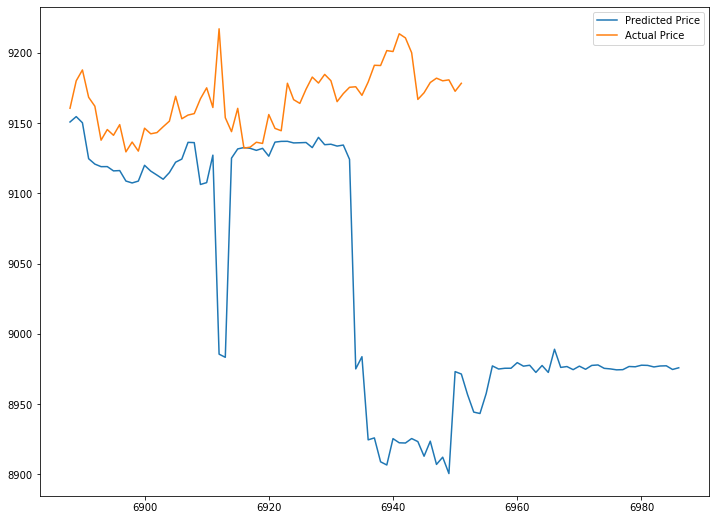

In [88]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(X_l['prediction'], label='Predicted Price')
ax.plot(X_l['target_btc'], label='Actual Price')
plt.legend()

In [174]:
mined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           6568 non-null   object 
 1   FLONetworkHashesPs  6568 non-null   float64
 2   FLOdifficulty       6568 non-null   int64  
 3   FLOblocks           6568 non-null   int64  
 4   BTCdifficulty       6568 non-null   float64
 5   BTCblocks           6568 non-null   float64
 6   FLOvolume           6568 non-null   float64
 7   FLOopenBuy          6568 non-null   int64  
 8   FLOopenSell         6568 non-null   int64  
 9   FLOlow              6568 non-null   float64
 10  FLOhigh             6568 non-null   float64
 11  FLObid              6568 non-null   float64
 12  FLOask              6568 non-null   float64
 13  FLObaseVol          6568 non-null   float64
 14  BTCvolume           6568 non-null   float64
 15  BTCopenBuy          6568 non-null   int64  
 16  BTCope

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
number = 1000
ax.plot(mined_df['scrypt_last30'].tail(number), label='Scrypt Last 30')
ax.plot(mined_df['scrypt_price'].tail(number), label='Scrypt Price')
plt.legend()
plt.ylim(0.00018, 0.0025)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
number = 1000
ax.plot(mined_df['scrypt_avail'].tail(number), label='Scrypt Last 30')
ax.plot(mined_df['scrypt_rented'].tail(number), label='Scrypt Price')
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
number = 1000
ax.plot(mined_df['FLOlast'].tail(number), label='FLO Last 30')

In [56]:
mrr_history = pd.read_csv('data/MiningRigRentals_Account_16811_Transactions-764549c0a7b1637205321727ad3c9b36 2.csv')

In [10]:
mrr_history = mrr_history[mrr_history["type"] != "Deposit"]
mrr_history.rental_id = mrr_history.rental_id.map(lambda x : int(x)) 
mrr_history.head()

,id,time,currency,type,amount,rental_id,rigid,info
0,12941925,2020-05-24 21:37:20,BTC,Credit/Refund,2.001000e-05,2810682,114093.0,Rental: 2810682 | Rig: 114093
1,12940164,2020-05-24 17:14:34,BTC,Payment,-2.132000e-05,2810682,114093.0,Rental: 2810682 | Rig: 114093
2,12940165,2020-05-24 17:14:34,BTC,Rental Fee,-4.300000e-07,2810682,114093.0,Rental: 2810682 | Rig: 114093
3,12940159,2020-05-24 17:14:33,BTC,Payment,-8.837000e-05,2810681,65796.0,Rental: 2810681 | Rig: 65796
4,12940160,2020-05-24 17:14:33,BTC,Rental Fee,-1.770000e-06,2810681,65796.0,Rental: 2810681 | Rig: 65796


In [11]:
#Saving the read list to disk
# out_list = pd.DataFrame(mrr_history['rental_id'].unique())
# out_list.to_csv('data/rental_read_list.csv')
# out_list.info()
mrr_history.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841],
           dtype='int64', length=1832)

In [41]:
rental_id = '2810682' 
with requests.get('https://www.miningrigrentals.com/api/v2/rental/'+rental_id) as response:
    html = response.text
rig_json = json.loads(html)

In [42]:
ad_price = rig_json['data']['price']['advertised']
paid_price = rig_json['data']['price']['paid']
hash_avg = rig_json['data']['hashrate']['average']['hash']
hash_adv = rig_json['data']['hashrate']['advertised']['hash']
extend = rig_json['data']['extended']
start = rig_json['data']['start']
end = rig_json['data']['end']
price_conv = rig_json['data']['price_converted']['advertised']

In [43]:
cols = ['rental_id', 'ad_price', 'paid_price', 'hash_avg', 'hash_adv', 'extend', 'start', 'end', 'price_conv']
df = pd.DataFrame(columns=cols)
df.loc[0] = [int(rental_id), ad_price, paid_price, hash_avg, hash_adv, extend, start, end, price_conv]
df.head()

,rental_id,ad_price,paid_price,hash_avg,hash_adv,extend,start,end,price_conv
0,2810682,0.00000031,0.00002132,0.034095280482682,0.55,0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.00031008


In [46]:
print(type(df.rental_id[0]))
save_list = pd.concat([mrr_history,df], axis=1, join='inner')
save_list.head(10)

<class 'int'>


,id,time,currency,type,amount,rental_id,rigid,info,rental_id,ad_price,paid_price,hash_avg,hash_adv,extend,start,end,price_conv
0,12941925,2020-05-24 21:37:20,BTC,Credit/Refund,0.00002,2810682,114093.0,Rental: 2810682 | Rig: 114093,2810682,0.00000031,0.00002132,0.034095280482682,0.55,0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.00031008


In [51]:
drops = ['id', 'time', 'currency', 'type', 'amount', 'rigid', 'info']
results_df = pd.read_csv('data/mrr_outfile.csv', index_col=0).drop(drops, axis=1)
results_df.head()

,rental_id,rental_id.1,ad_price,paid_price,hash_avg,hash_adv,extend,start,end,price_conv
0,2810682,NaN,3.100000e-07,0.000021,0.034095,0.5500,0.0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.000310
0,2810681,NaN,3.500000e-07,0.000088,2.119320,2.0000,0.0,2020-05-24 21:14:33 UTC,2020-05-25 00:14:33 UTC,0.000353
0,2810680,NaN,3.700000e-07,0.000017,0.375054,0.3750,0.0,2020-05-24 21:14:32 UTC,2020-05-25 00:14:32 UTC,0.000370
0,2810678,NaN,3.000000e-07,0.000022,0.612922,0.5985,0.0,2020-05-24 21:14:30 UTC,2020-05-25 00:14:30 UTC,0.000300
0,2810679,NaN,3.100000e-07,0.000109,2.936737,2.8000,0.0,2020-05-24 21:14:31 UTC,2020-05-25 00:14:31 UTC,0.000310


In [57]:
forDevon_df1 = mrr_history.merge(results_df, how='left', on='rental_id').drop('rental_id.1', axis=1)
forDevon_df1.head()

,id,time,currency,type,amount,rental_id,rigid,info,ad_price,paid_price,hash_avg,hash_adv,extend,start,end,price_conv
0,12941925,2020-05-24 21:37:20,BTC,Credit/Refund,2.001000e-05,2810682.0,114093.0,Rental: 2810682 | Rig: 114093,3.100000e-07,0.000021,0.034095,0.55,0.0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.000310
1,12940164,2020-05-24 17:14:34,BTC,Payment,-2.132000e-05,2810682.0,114093.0,Rental: 2810682 | Rig: 114093,3.100000e-07,0.000021,0.034095,0.55,0.0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.000310
2,12940165,2020-05-24 17:14:34,BTC,Rental Fee,-4.300000e-07,2810682.0,114093.0,Rental: 2810682 | Rig: 114093,3.100000e-07,0.000021,0.034095,0.55,0.0,2020-05-24 21:14:34 UTC,2020-05-25 00:14:34 UTC,0.000310
3,12940159,2020-05-24 17:14:33,BTC,Payment,-8.837000e-05,2810681.0,65796.0,Rental: 2810681 | Rig: 65796,3.500000e-07,0.000088,2.119320,2.00,0.0,2020-05-24 21:14:33 UTC,2020-05-25 00:14:33 UTC,0.000353
4,12940160,2020-05-24 17:14:33,BTC,Rental Fee,-1.770000e-06,2810681.0,65796.0,Rental: 2810681 | Rig: 65796,3.500000e-07,0.000088,2.119320,2.00,0.0,2020-05-24 21:14:33 UTC,2020-05-25 00:14:33 UTC,0.000353


In [58]:
forDevon_df.to_csv('data/MRR_scraped.csv')